# Covid Impacts with ANOVA

## The required libraries


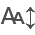

In [38]:
import pickle
import os
import numpy as np
import pandas as pd

pd.options.display.float_format = '{:,.2f}'.format

# Statistical libraries
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

# Visualization libraries
from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=True)
import matplotlib.pyplot as plt
import seaborn as sns

# Time series analysis libraries
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss

# Supress warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


### Load the Data

In [39]:
# Create a list of pickle files to load
pickle_files = ['all_weather_data.pkl',  
                'avg_NO2_daily.pkl']

# Open each pickle file and load the data based on the file name

for file in pickle_files:
    with open(file, 'rb') as f:
        if file == 'all_weather_data_daily.pkl':
            all_weather_data_daily = pickle.load(f)
        elif file == 'avg_NO2_daily.pkl':
            avg_NO2_daily = pickle.load(f)


# Create groups based on COVID

In [40]:
# Group the NO2 data into two groups: pre-COVID and post-COVID
covid_date = '2020-03-15'
# Reset the index to a column
avg_NO2_daily.reset_index(inplace=True)
avg_NO2_daily['COVID'] = np.where(avg_NO2_daily['date_local'] < covid_date, 'Pre-COVID', 'Post-COVID')

# Remove all rows with date_local >= covid_date + 1 year
avg_NO2_daily = avg_NO2_daily[avg_NO2_daily['date_local'] < '2021-03-15']
# Remove all rows with date_local < '2019-03-15'
avg_NO2_daily = avg_NO2_daily[avg_NO2_daily['date_local'] >= '2019-03-15']


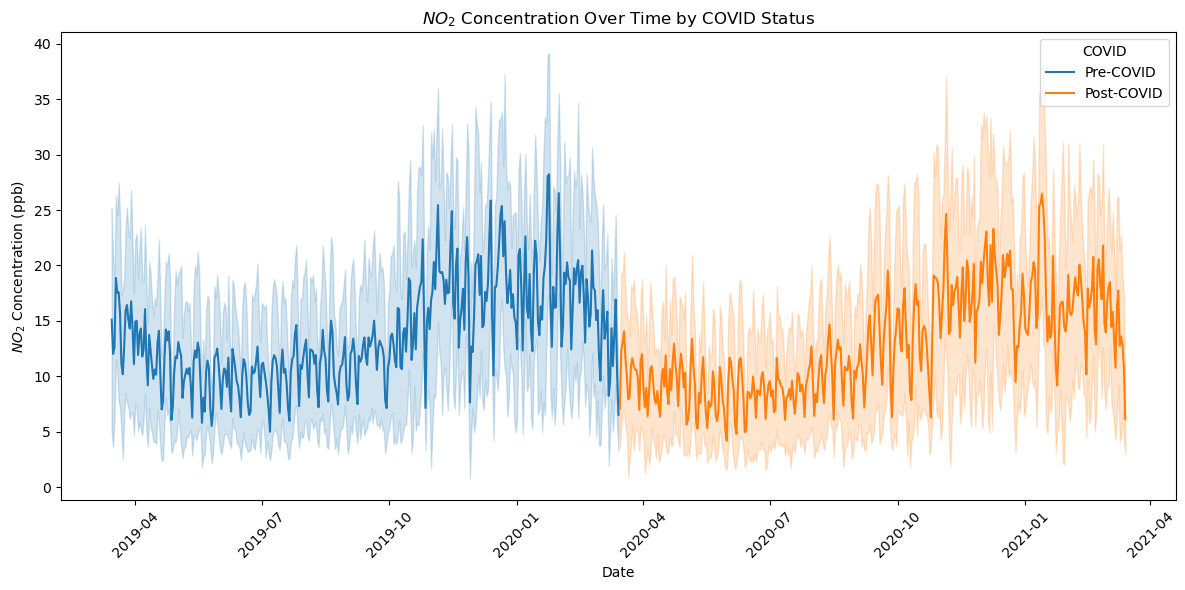

In [41]:
# Plot the time series of the NO2 concentrations by metro area and COVID status
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_NO2_daily, x='date_local', y='NO2_concentration', hue='COVID', errorbar='sd')
plt.title(r'$NO_2$ Concentration Over Time by COVID Status')
plt.xlabel('Date')
plt.ylabel(r'$NO_2$ Concentration (ppb)')
plt.xticks(rotation=45)
plt.tight_layout()


In [ ]:
# Create column for log of NO2 concentrations
avg_NO2_daily['NO2_log'] = np.log(avg_NO2_daily['NO2_concentration'])


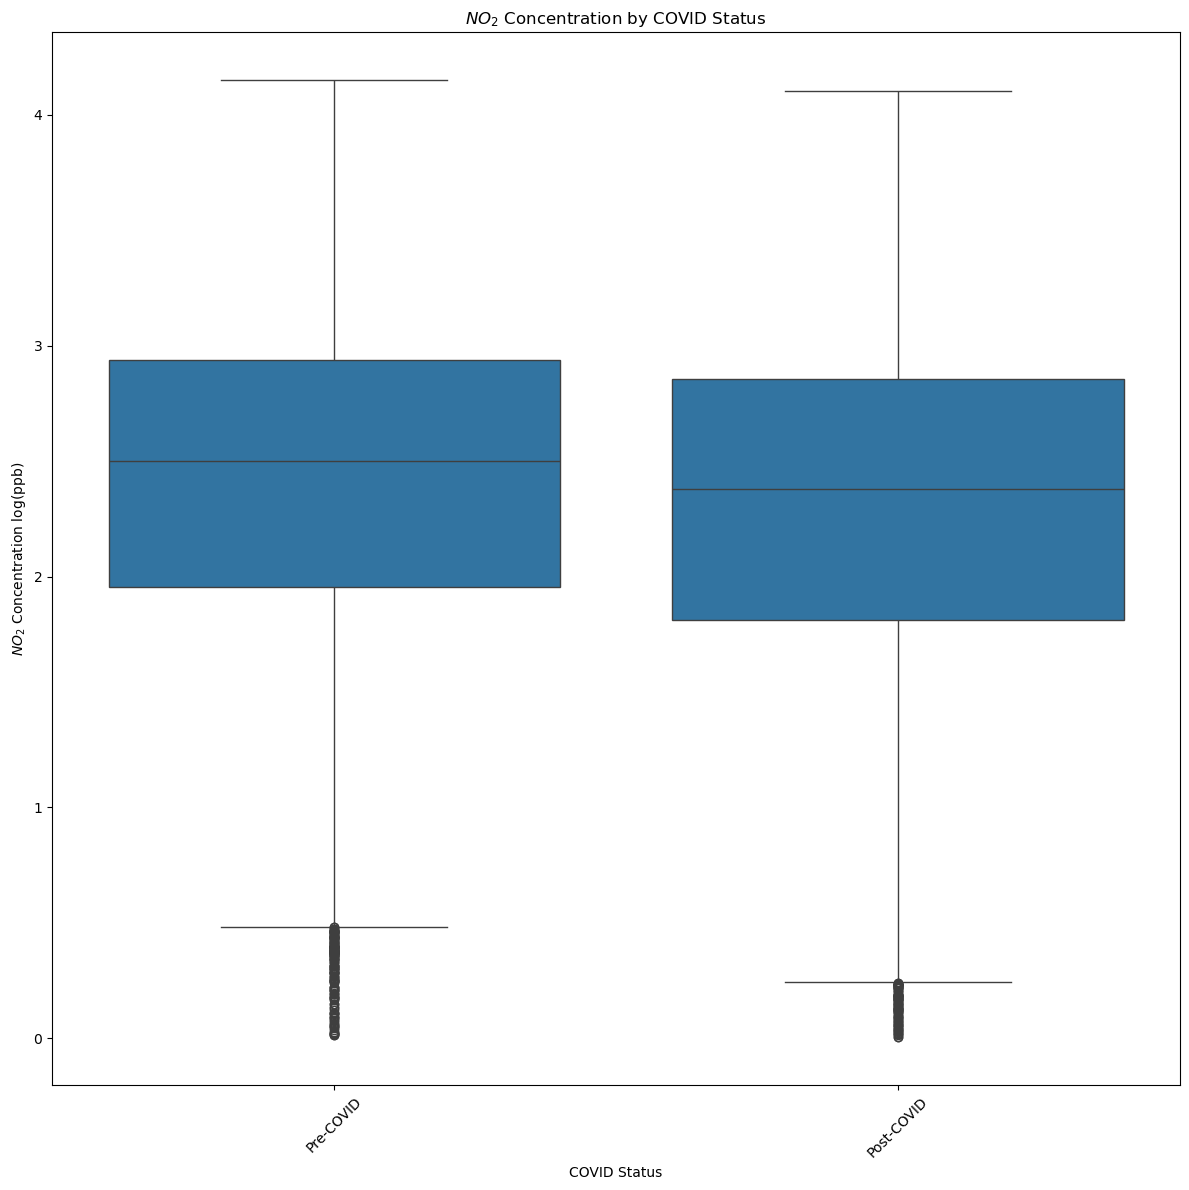

In [ ]:
# Create a boxplot of the NO2 concentrations by COVID status
plt.figure(figsize=(12, 12))
sns.boxplot(data=avg_NO2_daily, x='COVID', y='NO2_log')
plt.ylabel(r'$NO_2$ Concentration log(ppb)')
plt.xlabel('COVID Status')
plt.title(r'$NO_2$ Concentration by COVID Status')
plt.xticks(rotation=45)
plt.tight_layout()


### Metro Area Specific Visualization

### Impact by Metro Area

In [ ]:
# Create a list of unique metro areas
metro_areas = avg_NO2_daily['metro_area'].unique()
# Sort the metro areas in alphabetical order
metro_areas = sorted(metro_areas)


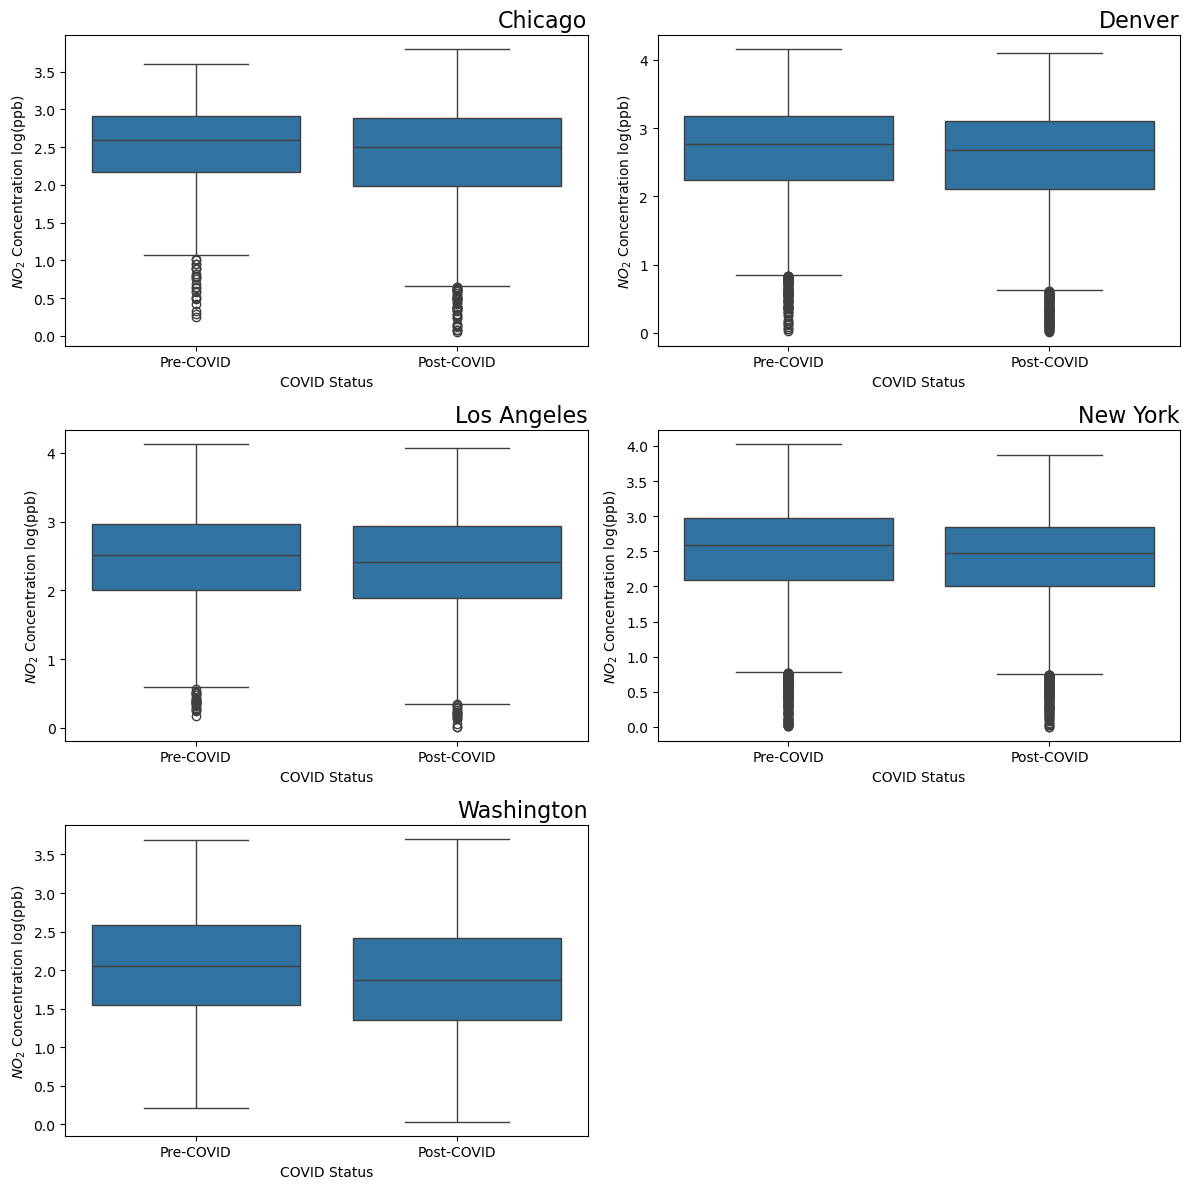

In [45]:
# Create the box-plots for the NO2 concentrations by metro area and COVID status
# Using a 3 x 2 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
# Flatten the axes array for easier indexing
axes = axes.flatten()
# Loop through each metro area and create a box-plot
for i, metro_area in enumerate(metro_areas):
    # Filter the data for the current metro area
    metro_data = avg_NO2_daily[avg_NO2_daily['metro_area'] == metro_area]
    # Create a box-plot for the current metro area
    sns.boxplot(data=metro_data, x='COVID', y='NO2_log', ax=axes[i])
    axes[i].set_title(f'{metro_area}', fontsize=16, loc='right')
    axes[i].set_xlabel('COVID Status')
    axes[i].set_ylabel(r'$NO_2$ Concentration log(ppb)')
    #axes[i].set_ylim(-3, 3)
# Remove the last empty subplot
axes[-1].axis('off')
fig.tight_layout()


## Fitting with GLM

### GLM Test for two group

In [46]:
# Perform glm() test for the two groups: pre-COVID and post-COVID
import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.genmod.generalized_linear_model import GLM

# Create a GLM model for the NO2 concentrations by COVID status
model = glm('NO2_concentration ~ COVID', data=avg_NO2_daily, family=sm.families.Gaussian(sm.families.links.Log())).fit()
# Print the summary of the model
print(model.summary())
# Print the coefficients of the model
print(model.params)


                 Generalized Linear Model Regression Results                  
Dep. Variable:      NO2_concentration   No. Observations:                35450
Model:                            GLM   Df Residuals:                    35448
Model Family:                Gaussian   Df Model:                            1
Link Function:                    Log   Scale:                          73.277
Method:                          IRLS   Log-Likelihood:            -1.2642e+05
Date:                Mon, 14 Apr 2025   Deviance:                   2.5975e+06
Time:                        19:52:21   Pearson chi2:                 2.60e+06
No. Iterations:                     6   Pseudo R-squ. (CS):           0.003812
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.5422      0

In [ ]:
# Create a GLM model for the NO2 concentrations by COVID status with gamma distribution
model = glm('NO2_concentration ~ COVID', data=avg_NO2_daily, family=sm.families.Gamma(sm.families.links.Log())).fit()
# Print the summary of the model
print(model.summary())
# Print the coefficients of the model
print(model.params)


                 Generalized Linear Model Regression Results                  
Dep. Variable:      NO2_concentration   No. Observations:                35450
Model:                            GLM   Df Residuals:                    35448
Model Family:                   Gamma   Df Model:                            1
Link Function:                    Log   Scale:                         0.42002
Method:                          IRLS   Log-Likelihood:            -1.2146e+05
Date:                Mon, 14 Apr 2025   Deviance:                       16640.
Time:                        19:52:21   Pearson chi2:                 1.49e+04
No. Iterations:                     7   Pseudo R-squ. (CS):           0.003799
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.5422      0

### GLM By Metro Area

In [48]:
# Perform the GLM test for each metro area
glm_results = []
for i, metro_area in enumerate(metro_areas):
    # Filter the data for the current metro area
    metro_data = avg_NO2_daily[avg_NO2_daily['metro_area'] == metro_area]
    # Create a GLM model for the NO2 concentrations by COVID status
    model = glm('NO2_concentration ~ COVID', data=metro_data, family=sm.families.Gaussian(sm.families.links.Log())).fit()
    # Report the r^2 value
    r2_cs = model.pseudo_rsquared(kind='cs')
    # Append the results
    glm_results.append([metro_area, model.params[1], model.pvalues[1], r2_cs, model.conf_int().iloc[1][0], model.conf_int().iloc[1][1]])
# Convert to data_frame
glm_results_df = pd.DataFrame(glm_results)
# Rename the columns for clarity
glm_results_df.columns = ['metro_area', 'coef', 'pval', 'R2(psedo)', 'conf_int_lower', 'conf_int_upper']

# Calculate the percentage change in the coefficients
glm_results_df['percent_change_coef'] = (np.exp(glm_results_df['coef'])-1)  *100
# Calculate the percentage change in the confidence intervals
glm_results_df['percent_change_lower'] = (np.exp(glm_results_df['conf_int_lower'])-1)  *100
glm_results_df['percent_change_upper'] = (np.exp(glm_results_df['conf_int_upper'])-1)  *100


# Print the results
print(glm_results_df)
show(glm_results_df)


    metro_area  coef  pval  R2(psedo)  conf_int_lower  conf_int_upper  \
0      Chicago  0.07  0.00       0.00            0.04            0.10   
1       Denver  0.09  0.00       0.01            0.05            0.13   
2  Los Angeles  0.04  0.00       0.00            0.02            0.06   
3     New York  0.11  0.00       0.01            0.08            0.13   
4   Washington  0.15  0.00       0.01            0.11            0.18   

   percent_change_coef  percent_change_lower  percent_change_upper  
0                 7.07                  3.75                 10.51  
1                 9.77                  5.64                 14.06  
2                 3.77                  1.52                  6.08  
3                11.36                  8.46                 14.34  
4                15.87                 11.97                 19.90  


## Examine GLM using differenced data

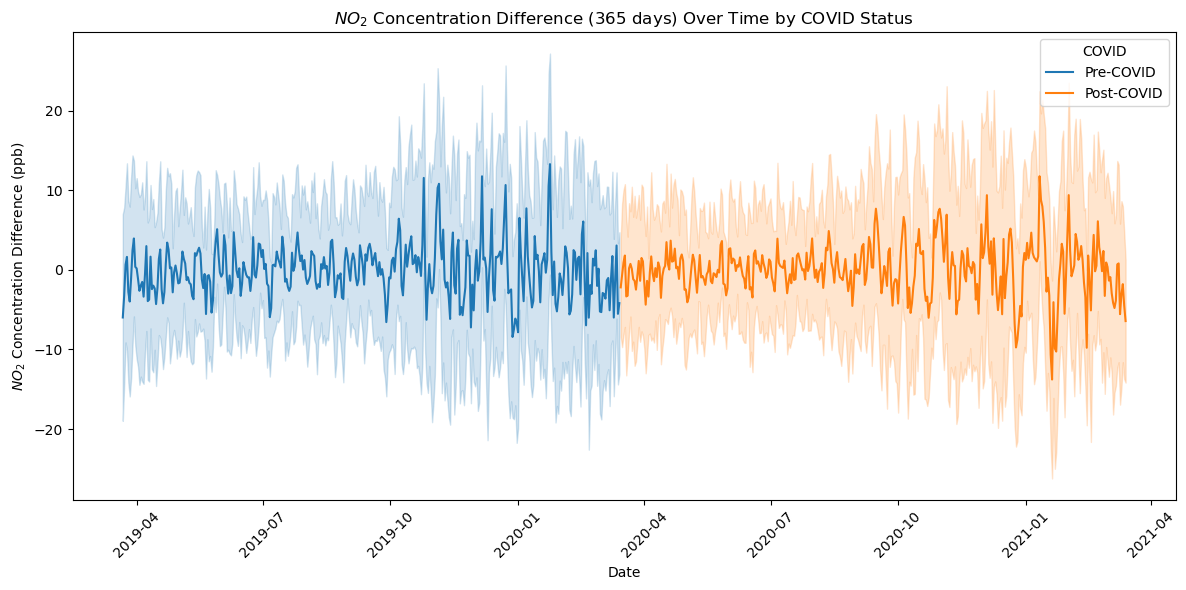

In [ ]:
# Create a data-set that is differenced by 365 days
avg_NO2_daily['NO2_concentration_diff'] = avg_NO2_daily['NO2_concentration'].diff(365)

# Plot the differenced time series of the NO2 concentrations by COVID status
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_NO2_daily, x='date_local', y='NO2_concentration_diff', hue='COVID', errorbar='sd')
plt.title(r'$NO_2$ Concentration Difference (365 days) Over Time by COVID Status')
plt.xlabel('Date')
plt.ylabel(r'$NO_2$ Concentration Difference (ppb)')
plt.xticks(rotation=45)
plt.tight_layout()


In [ ]:
# Perform the GLM test for each metro area using differenced data
glm_results = []
for i, metro_area in enumerate(metro_areas):
    # Filter the data for the current metro area
    metro_data = avg_NO2_daily[avg_NO2_daily['metro_area'] == metro_area]
    # Create a GLM model for the NO2 concentrations by COVID status
    model = glm('NO2_concentration_diff ~ COVID', data=metro_data, family=sm.families.Gaussian()).fit()
    # Append the results
    glm_results.append([metro_area, model.params[1], model.pvalues[1], model.conf_int().iloc[1][0], model.conf_int().iloc[1][1]])
# Convert to data_frame
glm_results_df = pd.DataFrame(glm_results)
# Rename the columns for clarity
glm_results_df.columns = ['metro_area', 'coef', 'pval', 'conf_int_lower', 'conf_int_upper']

# Print the results
print(glm_results_df)
show(glm_results_df)


    metro_area  coef  pval  conf_int_lower  conf_int_upper
0      Chicago -0.59  0.06           -1.22            0.03
1       Denver  0.46  0.23           -0.29            1.20
2  Los Angeles -0.66  0.00           -1.04           -0.28
3     New York  0.41  0.09           -0.06            0.87
4   Washington  0.25  0.28           -0.21            0.71


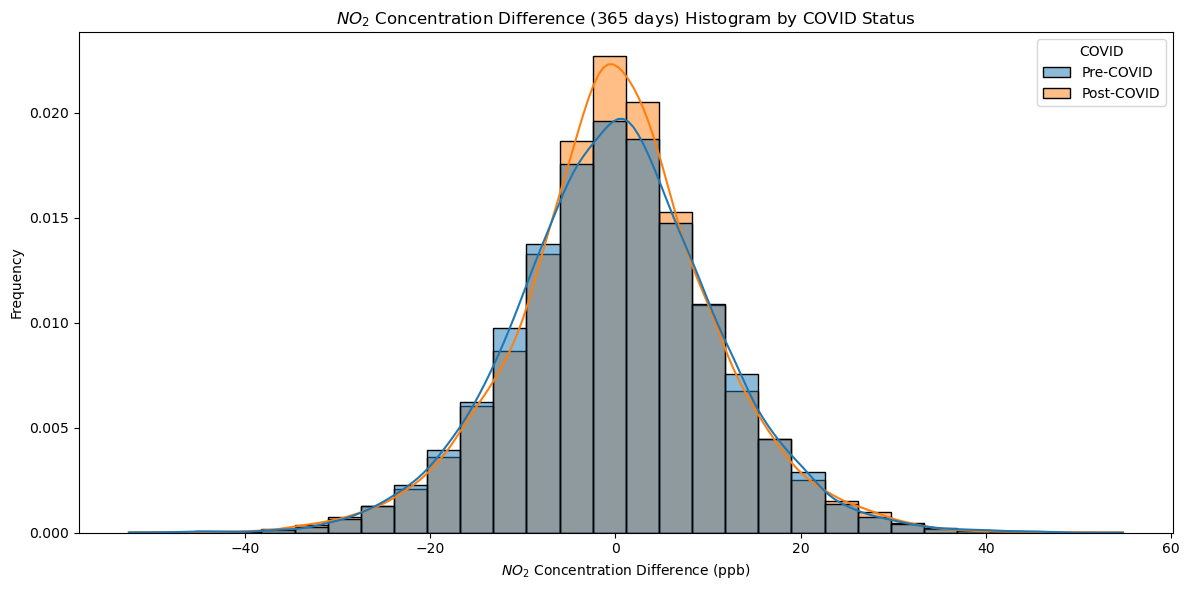

In [51]:
# Plot of histogram of NO2 concentration difference by COVID status
plt.figure(figsize=(12, 6))
sns.histplot(data=avg_NO2_daily, x='NO2_concentration_diff', hue='COVID', kde=True, bins=30, stat='density')
plt.title(r'$NO_2$ Concentration Difference (365 days) Histogram by COVID Status')
plt.xlabel(r'$NO_2$ Concentration Difference (ppb)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


### Exploring Averages by Week

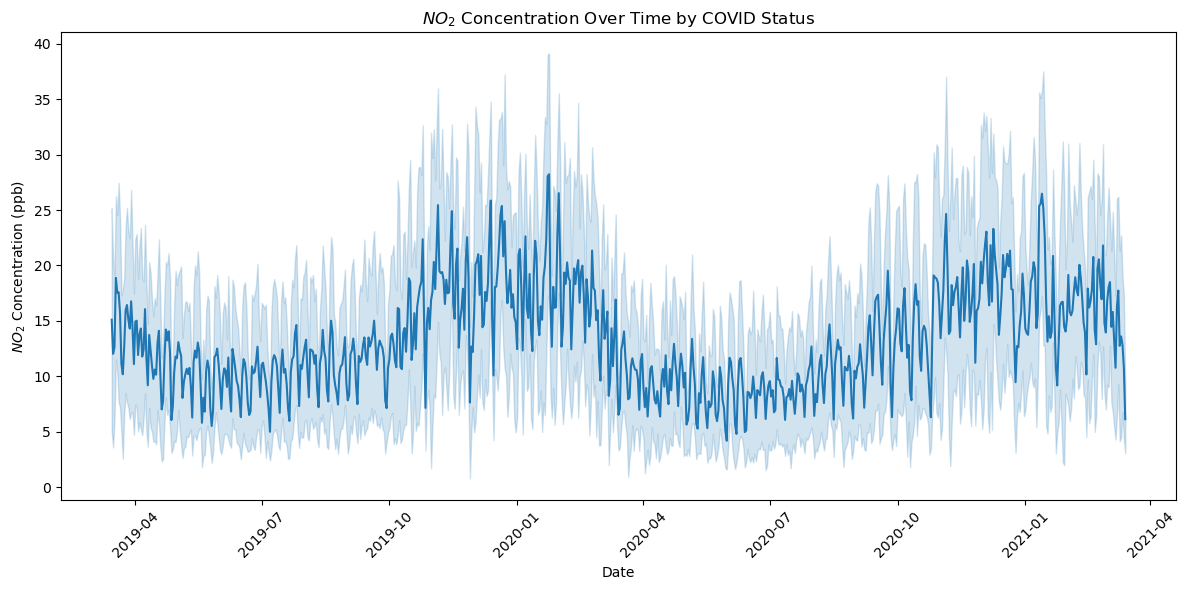

In [ ]:
# plot average_NO2_daily by date 
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_NO2_daily, x='date_local', y='NO2_concentration', errorbar='sd')
plt.title(r'$NO_2$ Concentration Over Time by COVID Status')
plt.xlabel('Date')
plt.ylabel(r'$NO_2$ Concentration (ppb)')
plt.xticks(rotation=45)
plt.tight_layout()


In [53]:
# Group by FIPS, FIPS_site, year, and week_of_year and calculate the mean NO2 concentration
avg_NO2_weekly = avg_NO2_daily.groupby(['fips', 'fips_site', 'metro_area', 'year', 'week_of_year']).agg({'NO2_concentration': 'mean'}).reset_index()

# Remove nan from the data
avg_NO2_weekly = avg_NO2_weekly[avg_NO2_weekly['NO2_concentration'].notna()]

# Create a column for year and week of year
avg_NO2_weekly['year_week'] = avg_NO2_weekly['year'].astype(str) + '-' + avg_NO2_weekly['week_of_year'].astype(str)


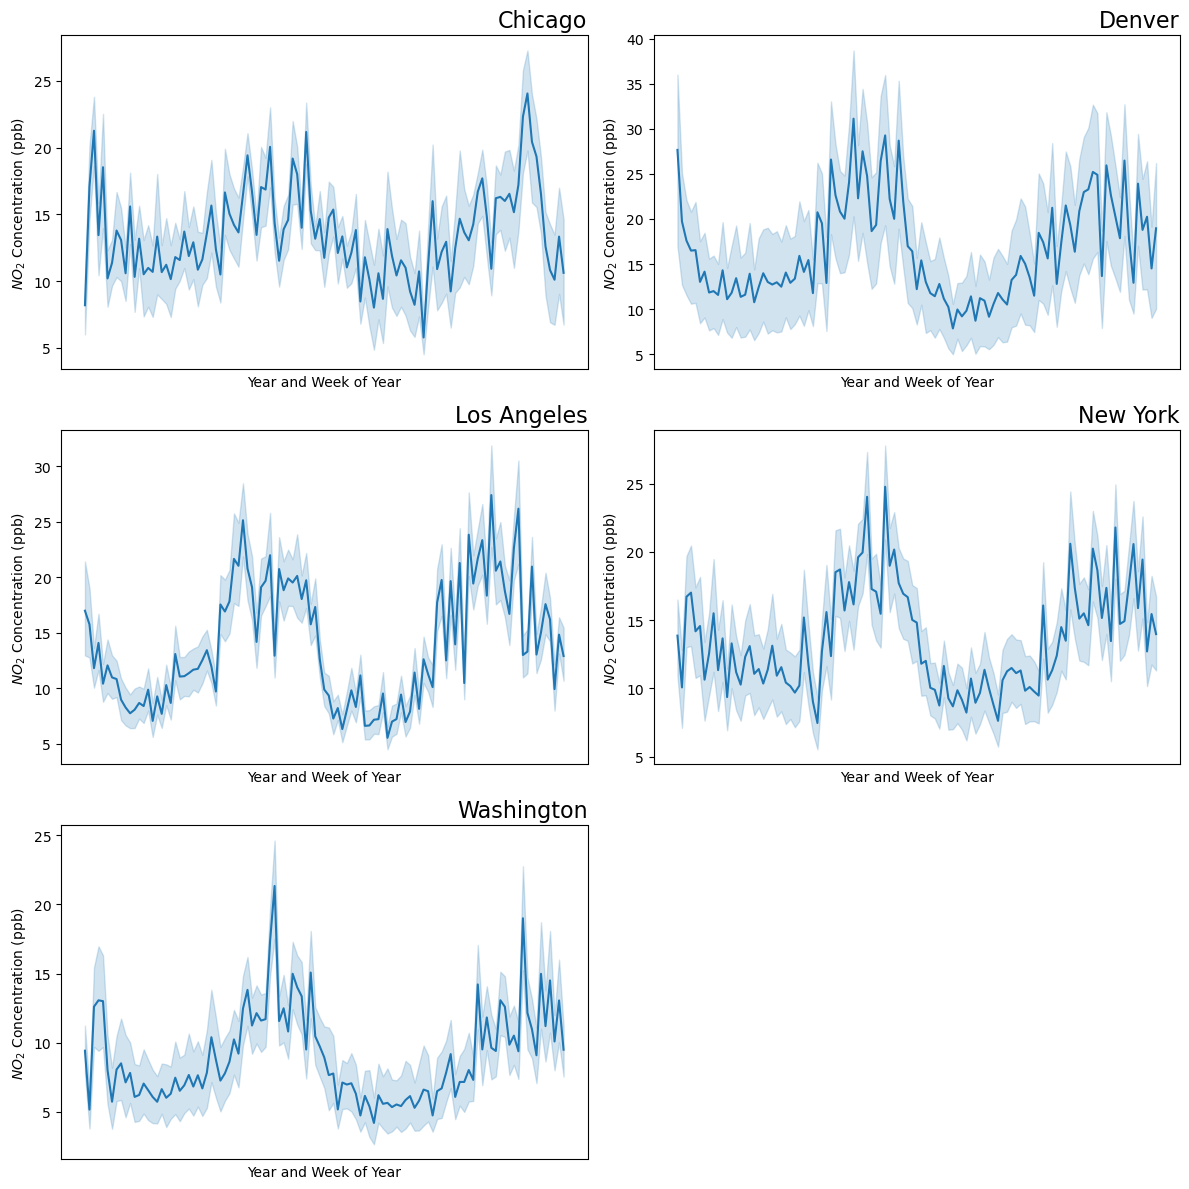

In [ ]:
# Plot the NO2 concentrations by year_week by metro area in a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
# Flatten the axes array for easier indexing
axes = axes.flatten()
# Loop through each metro area and create a line plot
for i, metro_area in enumerate(metro_areas):
    # Filter the data for the current metro area
    metro_data = avg_NO2_weekly[avg_NO2_weekly['metro_area'] == metro_area]
    # Create a line plot for the current metro area
    sns.lineplot(data=metro_data, x='year_week', y='NO2_concentration', ax=axes[i])
    axes[i].set_title(f'{metro_area}', fontsize=16, loc='right')
    axes[i].set_xlabel('Year and Week of Year')
    axes[i].set_ylabel(r'$NO_2$ Concentration (ppb)')
    # no x-tick
    axes[i].set_xticks([])

axes[-1].axis('off')
fig.tight_layout()


C:\Users\adams\AppData\Local\Temp\ipykernel_39228\3734995063.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metro_data['NO2_concentration_diff'] = metro_data['NO2_concentration'].diff(52)
C:\Users\adams\AppData\Local\Temp\ipykernel_39228\3734995063.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metro_data['NO2_concentration_diff'] = metro_data['NO2_concentration'].diff(52)
C:\Users\adams\AppData\Local\Temp\ipykernel_39228\3734995063.py:9: SettingWithCopyWarning: 
A value is trying to be set on a c

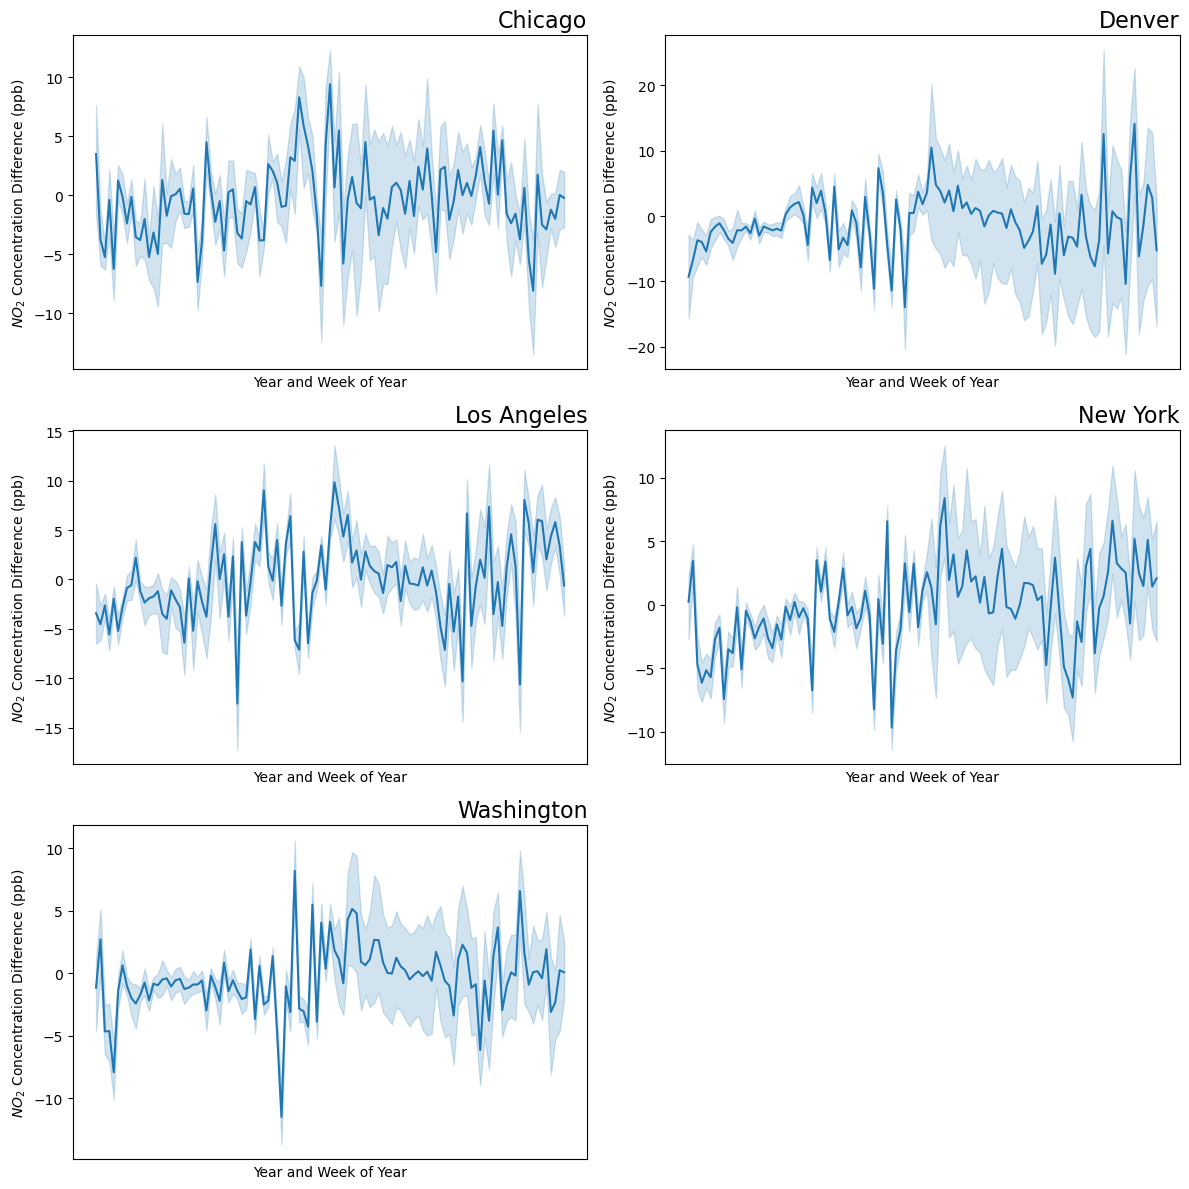

In [ ]:
# Plot the differenced NO2 concentrations by year_week by metro area in a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
# Flatten the axes array for easier indexing
axes = axes.flatten()
# Loop through each metro area and create a line plot
for i, metro_area in enumerate(metro_areas):
    # Filter the data for the current metro area
    metro_data = avg_NO2_weekly[avg_NO2_weekly['metro_area'] == metro_area]
    metro_data['NO2_concentration_diff'] = metro_data['NO2_concentration'].diff(52)
    # Remove nan from the data
    metro_data = metro_data[metro_data['NO2_concentration_diff'].notna()]
    # Create a line plot for the current metro area
    sns.lineplot(data=metro_data, x='year_week', y='NO2_concentration_diff', ax=axes[i])
    axes[i].set_title(f'{metro_area}', fontsize=16, loc='right')
    axes[i].set_xlabel('Year and Week of Year')
    axes[i].set_ylabel(r'$NO_2$ Concentration Difference (ppb)')
    # no x-tick
    axes[i].set_xticks([])

axes[-1].axis('off')
fig.tight_layout()
